# Hamilton for ML dataflows

#### Requirements:

- Install dependencies (listed in `requirements.txt`)

More details [here](https://github.com/DAGWorks-Inc/hamilton/blob/main/examples/model_examples/scikit-learn/README.md#using-hamilton-for-ml-dataflows).

***

Uncomment and run the cell below if you are in a Google Colab environment. It will:
1. Mount google drive. You will be asked to authenticate and give permissions.
2. Change directory to google drive.
3. Make a directory "hamilton-tutorials"
4. Change directory to it.
5. Clone this repository to your google drive
6. Move your current directory to the hello_world example
7. Install requirements.

This means that any modifications will be saved, and you won't lose them if you close your browser.

In [ ]:
## 1. Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')
## 2. Change directory to google drive.
# %cd /content/drive/MyDrive
## 3. Make a directory "hamilton-tutorials"
# !mkdir hamilton-tutorials
## 4. Change directory to it.
# %cd hamilton-tutorials
## 5. Clone this repository to your google drive
# !git clone https://github.com/DAGWorks-Inc/hamilton/
## 6. Move your current directory to the hello_world example
# %cd hamilton/examples/hello_world
## 7. Install requirements.
# %pip install -r requirements.txt
# clear_output()  # optionally clear outputs
# To check your current working directory you can type `!pwd` in a cell and run it.

***
Here we have a simple example showing how you can write a ML training and evaluation workflow with Hamilton. 
***

In [3]:
"""
Example script showing how one might setup a generic model training pipeline that is quickly configurable.
"""

import digit_loader
import iris_loader
import my_train_evaluate_logic

from hamilton import base, driver


def get_data_loader(data_set: str):
    """Returns the module to load that will procur data -- the data loaders all have to define the same functions."""
    if data_set == "iris":
        return iris_loader
    elif data_set == "digits":
        return digit_loader
    else:
        raise ValueError(f"Unknown data_name {data_set}.")


def get_model_config(model_type: str) -> dict:
    """Returns model type specific configuration"""
    if model_type == "svm":
        return {"clf": "svm", "gamma": 0.001}
    elif model_type == "logistic":
        return {"clf": "logistic", "penalty": "l2"}
    else:
        raise ValueError(f"Unsupported model {model_type}.")

***
For the purpose of this experiment, lets apply the following configuration:

- `_data_set` = 'digits'
- `_model_type` = 'logistic'

More details [here](https://github.com/DAGWorks-Inc/hamilton/blob/main/examples/model_examples/scikit-learn/README.md).
***

In [4]:
_data_set = 'digits'  # the data set to load
_model_type = 'logistic'  # the model type to fit and evaluate with

dag_config = {
    "test_size_fraction": 0.5,
    "shuffle_train_test_split": True,
}
# augment config
dag_config.update(get_model_config(_model_type))
# get module with functions to load data
data_module = get_data_loader(_data_set)
# set the desired result container we want
adapter = base.DefaultAdapter()
"""
What's cool about this, is that by simply changing the `dag_config` and the `data_module` we can
reuse the logic in the `my_train_evaluate_logic` module very easily for different contexts and purposes if
want to setup a generic model fitting and prediction dataflow!
E.g. if we want to support a new data set, then we just need to add a new data loading module.
E.g. if we want to support a new model type, then we just need to add a single conditional function
     to my_train_evaluate_logic.
"""
dr = driver.Driver(dag_config, data_module, my_train_evaluate_logic, adapter=adapter)
# ensure you have done "pip install "sf-hamilton[visualization]"" for the following to work:
# dr.visualize_execution(['classification_report', 'confusion_matrix', 'fit_clf'],
#                        f'./model_dag_{_data_set}_{_model_type}.dot', {"format": "png"})
results = dr.execute(["classification_report", "confusion_matrix", "fit_clf"])
for k, v in results.items():
    print(k, ":\n", v)

Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


classification_report :
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        91
           1       0.92      0.95      0.94        84
           2       0.98      1.00      0.99        83
           3       0.99      0.98      0.98        81
           4       0.95      0.99      0.97        95
           5       0.98      0.94      0.96        97
           6       0.97      0.98      0.97        85
           7       0.98      0.98      0.98        96
           8       0.91      0.90      0.91        96
           9       0.96      0.93      0.94        91

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899

confusion_matrix :
 [[90  0  0  0  1  0  0  0  0  0]
 [ 0 80  0  0  1  0  1  0  2  0]
 [ 0  0 83  0  0  0  0  0  0  0]
 [ 0  0  0 79  0  0  0  1  0  1]
 [ 0  1  0  0 94  0  0  0  0  0]
 [ 0  1  0  1  1 91  0  1  0  2

/Users/flaviassantos/github/hamilton/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


***
Here is the graph of execution for the digits data set:
***

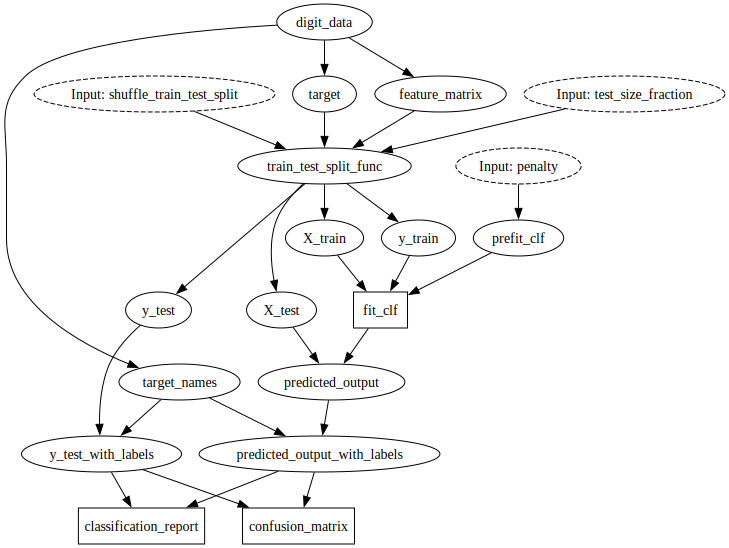

In [5]:
dr.visualize_execution(['classification_report', 'confusion_matrix', 'fit_clf'],
                       f'./model_dag_{_data_set}_{_model_type}.dot', {"format": "png"})